<PRE>
█▀▀ █▄░█ █▀ █▀▀ █▀▄▀█ █▄▄ █░░ █▀▀   █▀▀ █▄░█ █▄▄   █▄▀ █▄░█ █▄░█   █▀█ █▀▀
██▄ █░▀█ ▄█ ██▄ █░▀░█ █▄█ █▄▄ ██▄   █▄█ █░▀█ █▄█   █░█ █░▀█ █░▀█   █▀▄ █▀░
</PRE>

In [32]:
# Standard libraries
import math
import logging
from collections import Counter
from typing import Any, Dict, Optional, Tuple

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries for preprocessing and metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve

# Scikit-learn libraries for model selection
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

# Scikit-learn libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn libraries for pipeline
from sklearn.pipeline import make_pipeline

# Imbalanced-learn libraries
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [33]:
def initialize_data(scaler_type: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    
    # Pobranie danych z plików .csv
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    
    #Informacje o danych do logów
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")

    #Przeskalowanie danych przy użyciu obiektu MinMaxScaler
    if scaler_type in ["minmax", "standard"]:
        scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
        X = scaler.fit_transform(X)
        logging.info(f"Data scaled using {scaler_type} scaler.")
    else:
        logging.info("No scaling applied.")

    return X, y

In [34]:
#Funkcja definiująca strategię próbkowania
def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(1 * max_count), count) for class_label, count in zip(unique, counts)}

#Funkcja dzieląca dane na zbiór treningowy i testowy oraz nakladająca oversampler
def initialize_and_split_data(scaler_type: str, method: str = 'none') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data(scaler_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if method == 'smote':
        strategy = sampling_strategy(y_train)
        oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        logging.info(f"Applied {method} to handle class imbalance in the training data.")
    return X_train, X_test, y_train, y_test

#Funkcja ewaluująca model
def cross_validation_and_evaluation(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any], cv_splits: int = 5, random_state: int = 42) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list, Dict[str, Any]]:
    # Set the best parameters for the model
    model.set_params(**best_params)
    pipe = make_pipeline(model)

    # Perform cross-validation
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    logging.info(f"Cross-validation results: {cv_results}")


    logging.info(f"Mean accuracy score over all folds: {cv_results['test_score'].mean() * 100:.2f}%")
    logging.info(f"Mean training accuracy score over all folds: {cv_results['train_score'].mean() * 100:.2f}%")
    return cv_results, cv_results['test_score'].mean()

#Funkcja znajująca najlepsze hiperparametry
def optimize_hyperparameters(estimator, X_train: np.ndarray, y_train: np.ndarray, param_grid: Dict[str, Any], n_iter: int = 200, cv_splits: int = 5, random_state: int = 42) -> Dict[str, Any]:
    random_search = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_iter=n_iter, cv= cv_splits, scoring='accuracy', random_state=random_state, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    logging.info(f"Best accuracy score: {random_search.best_score_ * 100:.2f}%")
    logging.info(f"Best parameters: {random_search.best_params_}")
    return random_search.best_params_



In [35]:
def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    # Determine unique classes
    classes = [3, 4, 5, 6, 7, 8]

    report = classification_report(y_test, y_pred, labels=classes, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, labels=classes, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred, labels=classes))
    return report

#Funkcja generująca histogram
def plot_histogram(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot.hist(ax=ax, alpha=0.5)
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.legend(['Actual', 'Predicted'])

#Funkcja generująca wykres przewidywań vs właściwych ocen wina
def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot(ax=ax, marker='o')
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend(['Actual', 'Predicted'])

#Funkcja generująca raport klasyfikacji
def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

#Funkcja generująca macierz pomyłek
def plot_confusion_matrix(report: np.ndarray, classes: list, ax: plt.Axes) -> None:
    sns.heatmap(report, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

#Funkcja wywołująca wszystkie wykesy
def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    classes = [3, 4, 5, 6, 7, 8]
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    plot_confusion_matrix(confusion_matrix(y_fold_test, y_pred, labels=classes), classes, axs[0, 1])
    plot_classification_report(report, axs[1, 0])
    plot_histogram(y_fold_test, y_pred, axs[2, 1])
    
    axs[1, 1].plot(cv_results['test_score'], label='Test Score')
    axs[1, 1].plot(cv_results['train_score'], label='Train Score')
    axs[1, 1].set_title('Cross-validation Results with Optimized Hyperparameters')
    axs[1, 1].set_xlabel('Fold Index')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    axs[2, 0].bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    axs[2, 0].set_title('Comparison of Model Performance')
    axs[2, 0].set_ylabel('Mean Accuracy Score')
    
    plt.tight_layout()
    plt.show()

2024-06-04 13:17:17,099 - INFO - X shape: (1503, 9), y shape: (1503,)
2024-06-04 13:17:17,102 - INFO - Data scaled using standard scaler.


2024-06-04 13:17:17,127 - INFO - Applied smote to handle class imbalance in the training data.
2024-06-04 13:17:17,129 - INFO - Data initialization and splitting complete.
2024-06-04 13:17:20,644 - INFO - Cross-validation results: {'fit_time': array([0.6866672 , 0.61663175, 0.62433529, 0.62223005, 0.61261892]), 'score_time': array([0.01564074, 0.01566195, 0.01562881, 0.01562047, 0.03125811]), 'test_score': array([0.82419355, 0.83844911, 0.84491115, 0.85621971, 0.81421648]), 'train_score': array([0.94709208, 0.93379088, 0.94792087, 0.9430763 , 0.94186516])}
2024-06-04 13:17:20,660 - INFO - Mean accuracy score over all folds: 83.56%
2024-06-04 13:17:20,660 - INFO - Mean training accuracy score over all folds: 94.27%


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


2024-06-04 13:29:40,662 - INFO - Best accuracy score: 87.82%
2024-06-04 13:29:40,662 - INFO - Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_depth': 10, 'rf__bootstrap': False, 'knn__weights': 'distance', 'knn__n_neighbors': 3, 'knn__metric': 'manhattan', 'gnb__var_smoothing': 0.657933224657568}
2024-06-04 13:29:49,407 - INFO - Cross-validation results: {'fit_time': array([1.78161573, 1.59337783, 1.61348224, 1.63185453, 1.60941815]), 'score_time': array([0.0312407 , 0.03129363, 0.03125358, 0.01560736, 0.03124022]), 'test_score': array([0.86290323, 0.87399031, 0.87722132, 0.87883683, 0.86106624]), 'train_score': array([1.        , 1.        , 1.        , 0.99959629, 1.        ])}
2024-06-04 13:29:49,407 - INFO - Mean accuracy score over all folds: 87.08%
2024-06-04 13:29:49,407 - INFO - Mean training accuracy score over all folds: 99.99%
2024-06-04 13:29:51,364 - INFO - Classification report:
              precision    recall 

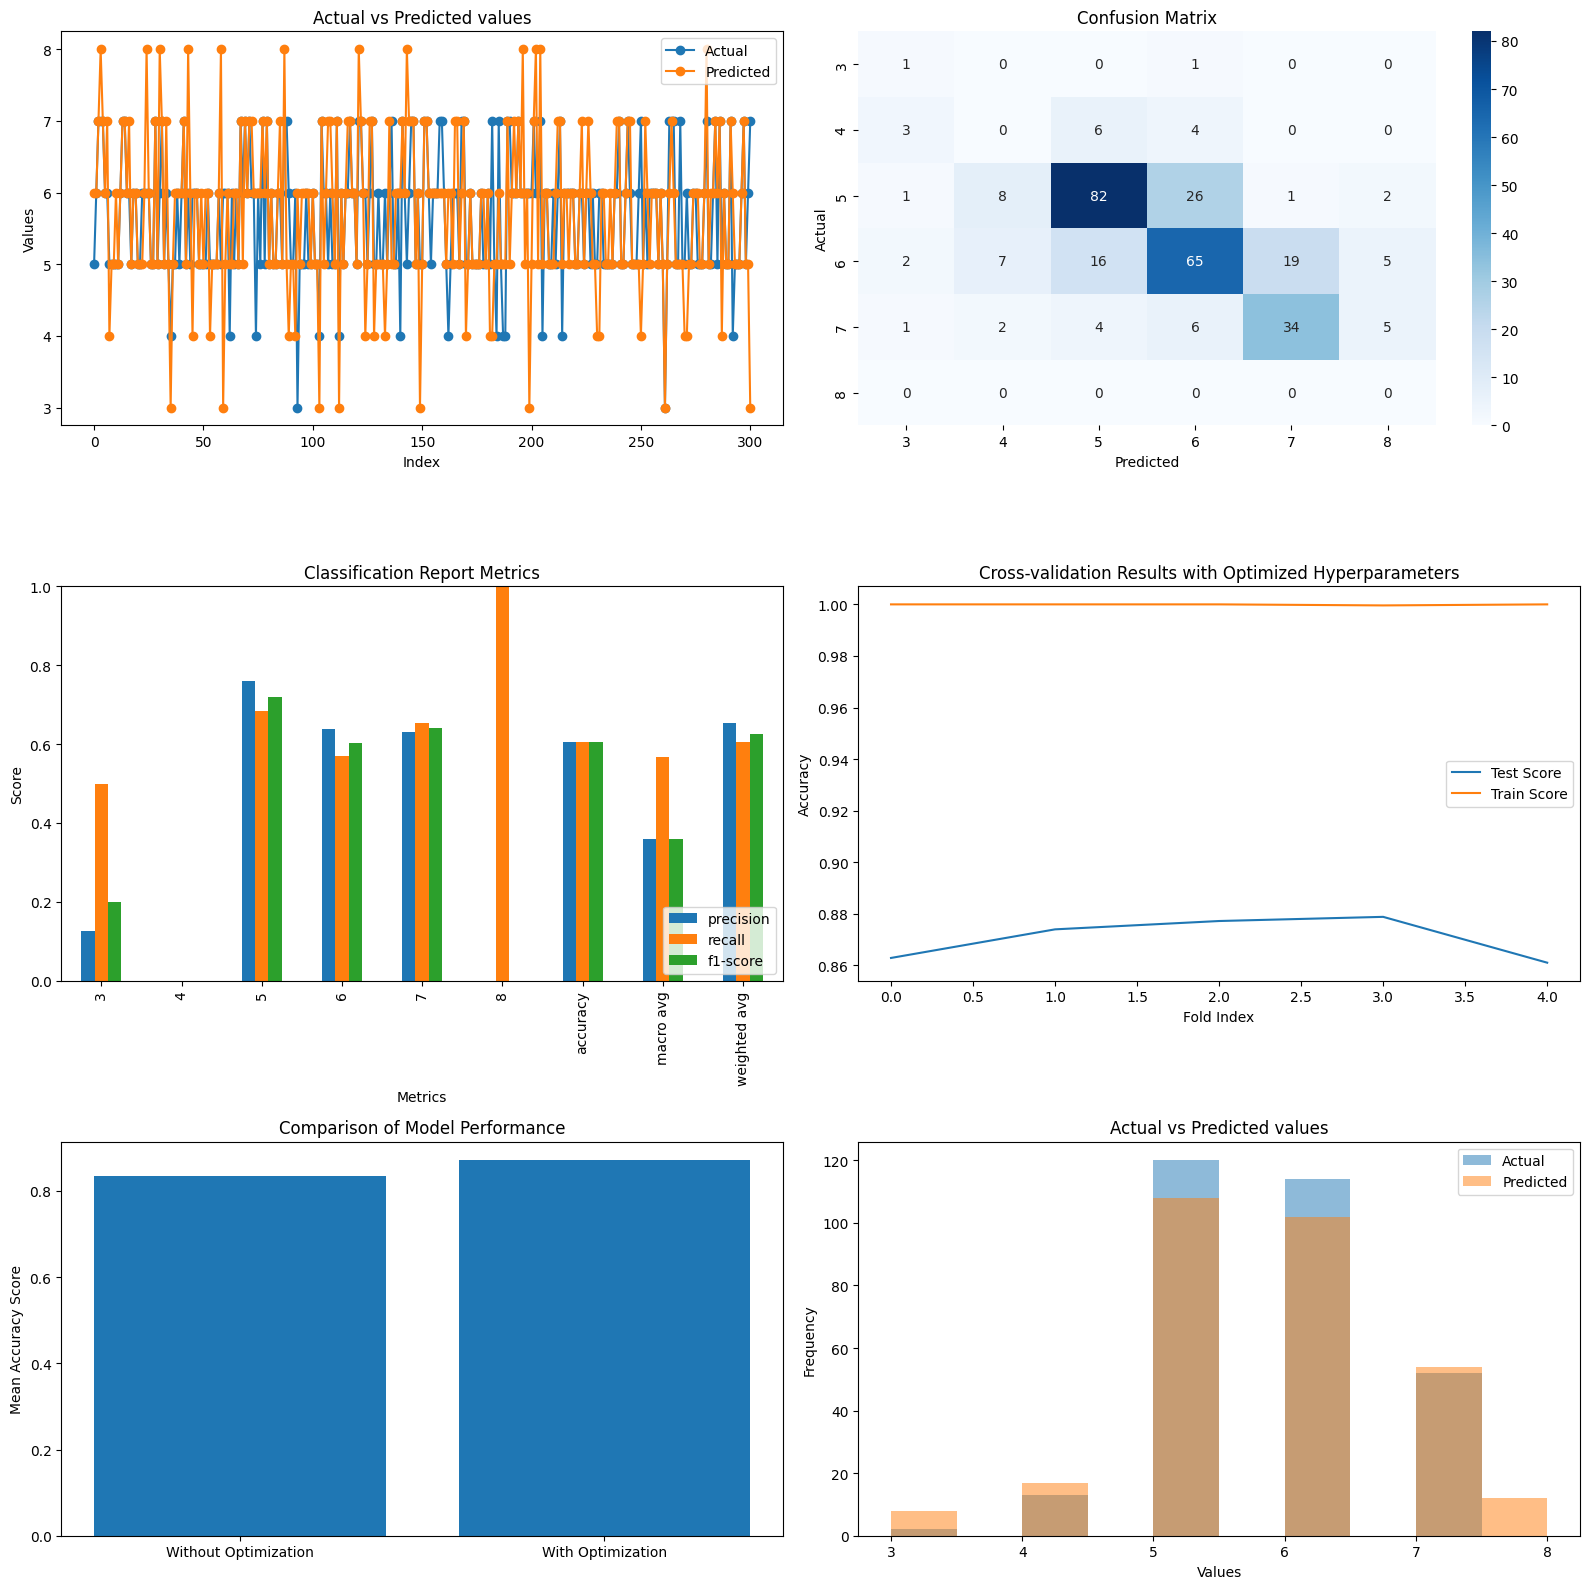

In [36]:

def ensemble_main():
    try:
        #Podział danych na zbior testowy i treningowy
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'smote')
        logging.info("Data initialization and splitting complete.")

        #Utworzenie obiektów modeli
        clf1 = GaussianNB()
        clf2 = RandomForestClassifier()
        clf3 = KNeighborsClassifier()

        #Utworzenie obiektu modelu ensemble
        eclf = VotingClassifier(estimators=[('gnb', clf1), ('rf', clf2), ('knn', clf3)], voting='soft')

        #Wytrenowanie i wstepna ocena modelu
        best_params = {}
        cv_results, accuracy_without_optimization = cross_validation_and_evaluation(X_train, y_train, eclf, best_params)

        #Hiperparametryzacja
        # Note: You need to specify the hyperparameters for each classifier separately
        param_grid = {
            'gnb__var_smoothing': np.logspace(0, -9, num=100),
            'rf__n_estimators': [50, 100, 200, 300, 400],
            'rf__max_depth': [None, 10, 20, 30, 40],
            'rf__min_samples_split': [2, 5, 10],
            'rf__min_samples_leaf': [1, 2, 4],
            'rf__bootstrap': [True, False],
            'knn__n_neighbors': [3, 5, 7, 9, 11],
            'knn__weights': ['uniform', 'distance'],
            'knn__metric': ['euclidean', 'manhattan']
        }
        best_params = optimize_hyperparameters(eclf, X_train, y_train, param_grid)

        #Walidacja krzyżowa modelu ze zoptymalizowanymi hiperparametrami
        cv_resultsOPT, accuracy_with_optimization = cross_validation_and_evaluation(X_train, y_train, eclf, best_params)

        #Ponowne wyktrenowanie modelu, ale ze zoptymalizowanymi hiperparametrami
        eclf.set_params(**best_params)
        eclf.fit(X_train, y_train)

        #Predykcje na zbiorze testowym
        y_pred_optimized = eclf.predict(X_test)

        #Generacja raportu dla modelu
        report_optimized = generate_report(y_test, y_pred_optimized)

        #Generacja wykresów dla modelu
        display_plots(y_test, y_pred_optimized, report_optimized, cv_resultsOPT, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    ensemble_main()